# Credit Card Fraud Detection Using Autoencoder

## Deep learning

Итак, мы добрались и до глубокого обучения. Все указанные выше классические методы были довольно требовательны: нам приходилось усердно работать с данными и параметрами самих моделей, чтобы добиться результата. Есть ли альтернатива?

### Автокодировщик

<img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/autoencoder.jpeg?w=638&ssl=1" width=800>

Как видно из рисунка, автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.

Как мы можем использовать автокодировщик для обнаружения мошеннических транзакций? Автокодировщиком мы пытаемся оптимизировать модель (то есть параметры модели), чтобы минимизировать ошибку реконструкции.

Теперь предположим, что мы подаем цифру 5 и на выходе получаем восстановленную цифру 5 с минимальной ошибкой восстановления. Теперь попробуем скормить другую цифру, которая пытается имитировать 5, когда мы получим на выходах ее восстановленную версию, она будет с большой ошибкой реконструкции. Это логика использования автокодировщика для обнаружения мошенничества. На вход подаем вектор из признаков (30 признаков).

## Declare required dependencies

In [1]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

## Data ingestion

In [2]:
url = "https://raw.githubusercontent.com/KoJl9lH-59rus/ML_KT/refs/heads/main/%D0%9A%D0%A21/content/transaction_dataset.csv"
df = pd.read_csv(url)

## Data exploration

In [3]:
df.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [4]:
print(df.shape)
print(df.describe())

(9841, 51)
        Unnamed: 0        Index         FLAG  Avg min between sent tnx  \
count  9841.000000  9841.000000  9841.000000               9841.000000   
mean   4920.000000  1815.049893     0.221421               5086.878721   
std    2840.996333  1222.621830     0.415224              21486.549974   
min       0.000000     1.000000     0.000000                  0.000000   
25%    2460.000000   821.000000     0.000000                  0.000000   
50%    4920.000000  1641.000000     0.000000                 17.340000   
75%    7380.000000  2601.000000     0.000000                565.470000   
max    9840.000000  4729.000000     1.000000             430287.670000   

       Avg min between received tnx  Time Diff between first and last (Mins)  \
count                   9841.000000                             9.841000e+03   
mean                    8004.851184                             2.183333e+05   
std                    23081.714801                             3.229379e+05   
mi

In [5]:
print(f"Процент мошенничских транзакций - {df['FLAG'].value_counts()[0]/df['FLAG'].count()*100}%")
print(f"Процент не мошенничских транзакций - {df['FLAG'].value_counts()[1]/df['FLAG'].count()*100}%")

Процент мошенничских транзакций - 77.85794126613149%
Процент не мошенничских транзакций - 22.14205873386851%


## Ести ли пропуски?

In [6]:
df.isnull().values.any()

True

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                          9841

In [8]:
filtered_df = df[df['FLAG'] == 1]
null_counts = (filtered_df.isna()).sum()

print("Количество мошеннических операций и пустых значений по столбцам:\n")
null_counts

Количество мошеннических операций и пустых значений по столбцам:



,0
Unnamed: 0,0
Index,0
Address,0
FLAG,0
Avg min between sent tnx,0
Avg min between received tnx,0
Time Diff between first and last (Mins),0
Sent tnx,0
Received Tnx,0
Number of Created Contracts,0


829 Мошеннчиеских наблюдений удалять не вариант, заполним датасет:

In [9]:
#Замена пустых значений в числовых столбцах на средние значения (МОЖЕТ НЕ СРЕДНЕЕ ПОПРОБОВАТЬ А -1)
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(-1)

In [10]:
# Замена пустых значений в столбцах типа object на 'none'
obj_cols = df.select_dtypes(include=['object']).columns
df[obj_cols] = df[obj_cols].fillna('none')

In [11]:
#df = df.dropna()

In [12]:
df.isnull().values.any()

False

Все пустые ячейки заполнены

In [13]:
from sklearn.preprocessing import LabelEncoder
object_columns = df.select_dtypes(include=['object']).columns.tolist()

# Инициализируем LabelEncoder
le = LabelEncoder()
# Преобразуем категориальные столбцы в числа
for col in object_columns:
    df[col] = le.fit_transform(df[col])

#Чистка

Убираем ненужны стробцы

In [14]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('Index', axis=1, inplace=True)

## Class distribution ( 0 - обычная, 1 - мошенническая)

In [15]:
df['FLAG'].value_counts()

,count
FLAG,
0,7662
1,2179


In [16]:
print(f"Процент мошенничских транзакций - {(df['FLAG'].value_counts()[0]/df['FLAG'].count() * 100).round(1)}%")
print(f"Процент не мошенничских транзакций - {(df['FLAG'].value_counts()[1]/df['FLAG'].count() * 100).round(1)}%")

Процент мошенничских транзакций - 77.9%
Процент не мошенничских транзакций - 22.1%


<ipython-input-17-abf17689d300>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=df['FLAG'], palette=colors)


<Axes: title={'center': 'Тип транзакции \n (0: Не мошенническая || 1: Мошенническая)'}, xlabel='FLAG', ylabel='count'>

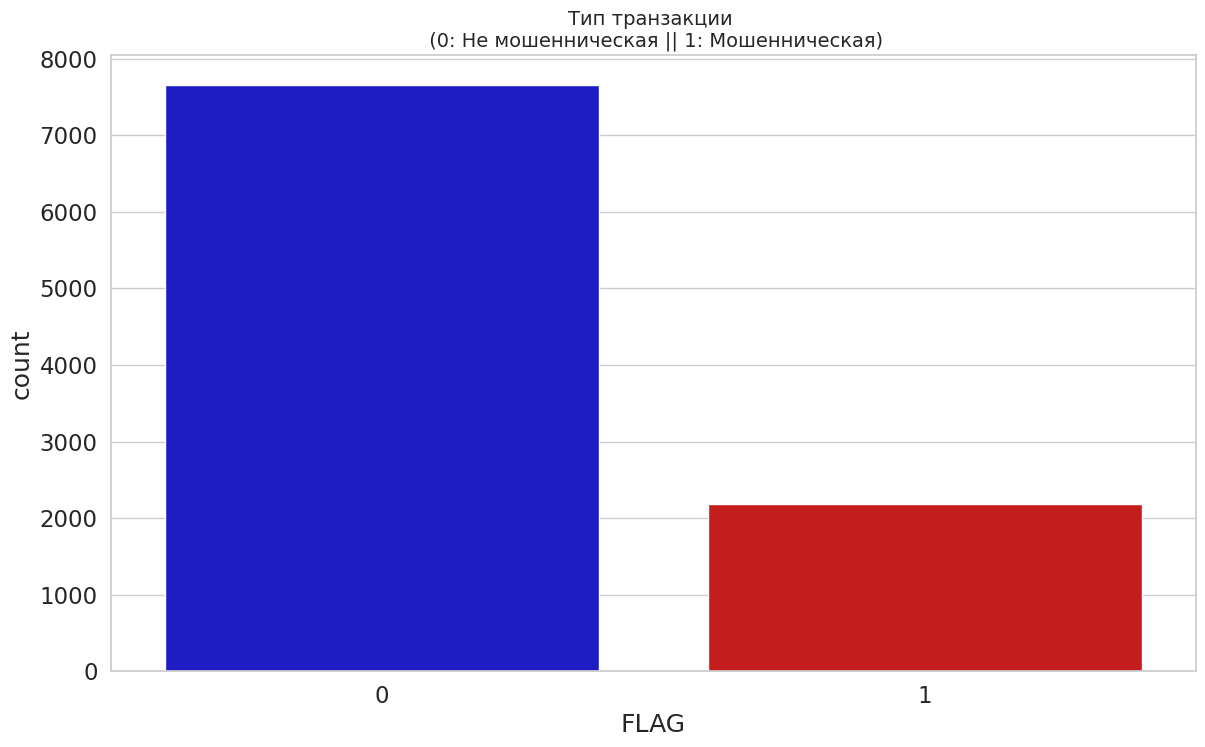

In [17]:
colors = ["#0101DF", "#DF0101"]

 # строим гистограмму целевой переменной:

plt.title('Тип транзакции \n (0: Не мошенническая || 1: Мошенническая)', fontsize=14)
sns.countplot(data=df, x=df['FLAG'], palette=colors)

Наш набор данных очень сильно несбалансирован в пользу отрицательного (0, то есть нормального) класса. Это требует дальнейшего изучения данных

### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 80% и тест = 20%. В обучающем наборе данных будут только обычные транзакции, а в тестовом наборе данных будут как обычные, так и мошеннические транзакции.

In [18]:
#Сначала разделяем на тестовую и тренировочную выборки, а после делаем снадартизацию
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

X_train = X_train[X_train['FLAG'] == 0]
X_train = X_train.drop(['FLAG'], axis=1)

num_cols = X_train.select_dtypes(include=['number']).columns

X_train[num_cols] = StandardScaler().fit_transform(X_train[num_cols])

num_cols = X_train.select_dtypes(include=['number']).columns

X_test[num_cols] = StandardScaler().fit_transform(X_test[num_cols])

y_test = X_test['FLAG']
X_test = X_test.drop(['FLAG'], axis=1)



X_train = X_train.values
X_test = X_test.values
y_test = y_test.values

print(X_train)


[[-1.44996499 -0.24181171 -0.2521487  ... -0.27850259 -0.77492053
  -0.73537345]
 [-0.86121981  0.5771176   1.56201996 ... -0.16801148  0.63881393
  -0.07334959]
 [ 1.25885383 -0.24074387 -0.38345334 ... -0.27850259 -0.77492053
  -0.73537345]
 ...
 [ 0.70778243 -0.24211466 -0.38345334 ... -0.27850259 -0.77492053
  -0.73537345]
 [-1.34765482 -0.23434577 -0.38345334 ... -0.27850259 -0.77492053
  -0.73537345]
 [ 1.55544253 -0.2420187  -0.38344892 ... -0.27850259 -0.77492053
  -0.73537345]]


## Model
Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с 14,7,7,29 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер. Обратите внимание, что последний слой имеет 48 узлов, соответствующих 48 функциям в элементе входных данных.

In [19]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(48, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(7, 7),
           nn.Tanh(),
           nn.Linear(7, 48),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
model = Autoencoder().double()

In [21]:
num_epochs = 100   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32
learning_rate = 1e-3

**minibatch_size** - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов  мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик.
По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.


**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [22]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)

In [23]:
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [24]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)

In [25]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [26]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/100], loss:0.8323
epoch [2/100], loss:0.7899
epoch [3/100], loss:0.7437
epoch [4/100], loss:0.7214
epoch [5/100], loss:0.7062
epoch [6/100], loss:0.6953
epoch [7/100], loss:0.6781
epoch [8/100], loss:0.6686
epoch [9/100], loss:0.6617
epoch [10/100], loss:0.6557
epoch [11/100], loss:0.6503
epoch [12/100], loss:0.6450
epoch [13/100], loss:0.6403
epoch [14/100], loss:0.6342
epoch [15/100], loss:0.6287
epoch [16/100], loss:0.6252
epoch [17/100], loss:0.6174
epoch [18/100], loss:0.6120
epoch [19/100], loss:0.6075
epoch [20/100], loss:0.6038
epoch [21/100], loss:0.5987
epoch [22/100], loss:0.5949
epoch [23/100], loss:0.5914
epoch [24/100], loss:0.5885
epoch [25/100], loss:0.5857
epoch [26/100], loss:0.5820
epoch [27/100], loss:0.5788
epoch [28/100], loss:0.5762
epoch [29/100], loss:0.5743
epoch [30/100], loss:0.5720
epoch [31/100], loss:0.5672
epoch [32/100], loss:0.5643
epoch [33/100], loss:0.5626
epoch [34/100], loss:0.5598
epoch [35/100], loss:0.5631
epoch [36/100], loss:0.6590
e

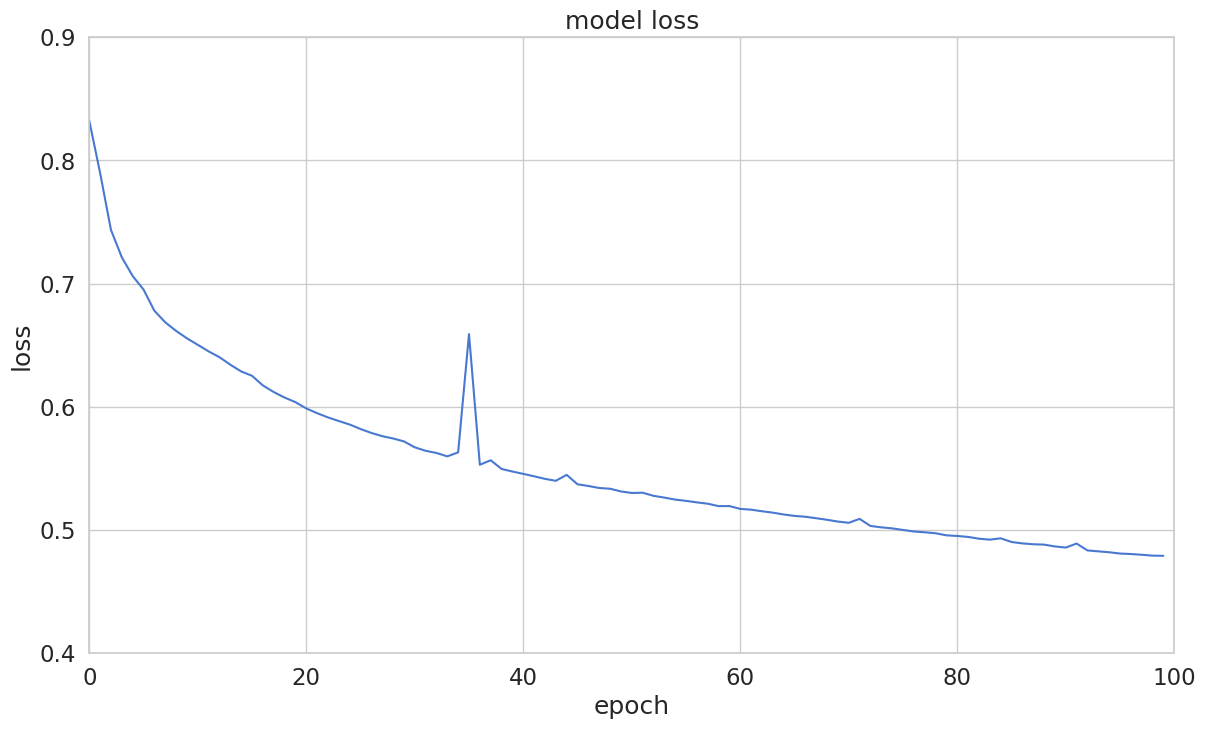

In [27]:
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,0.4,0.90])
plt.show()

## Оценка модели

In [28]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

In [29]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,1969.000000,1969.000000
mean,0.718166,0.216861
std,5.089875,0.412212
min,0.021736,0.000000
25%,0.057329,0.000000
50%,0.066094,0.000000
75%,0.109928,0.000000
max,121.788649,1.000000


# Reconstruction Errors without Fraud

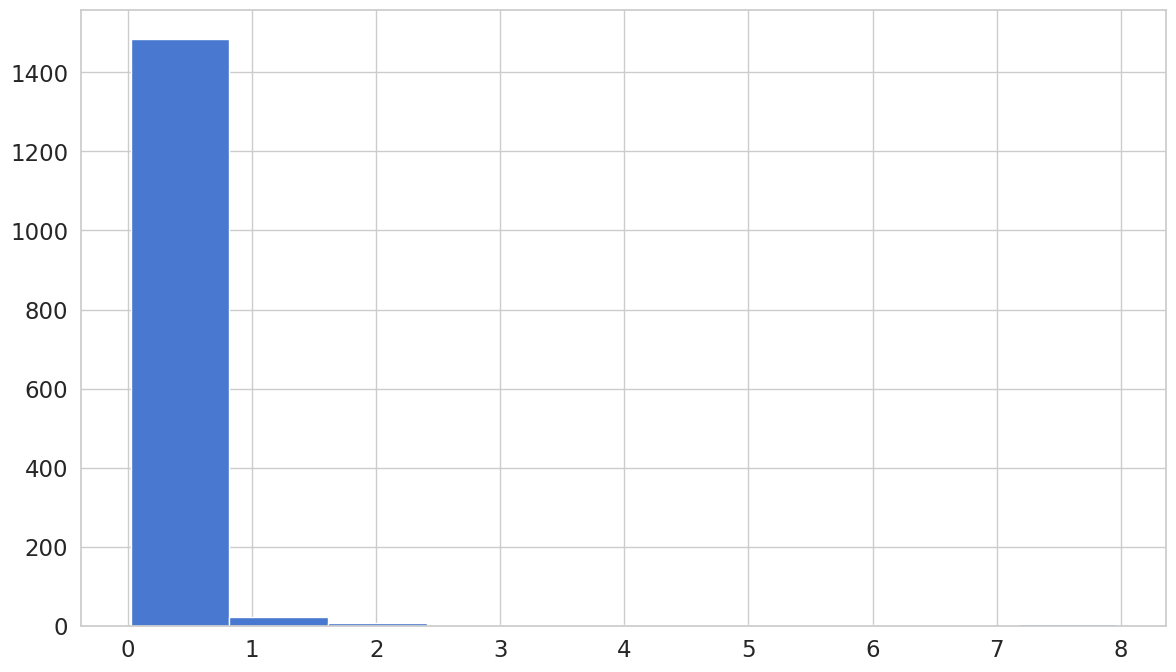

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with Fraud

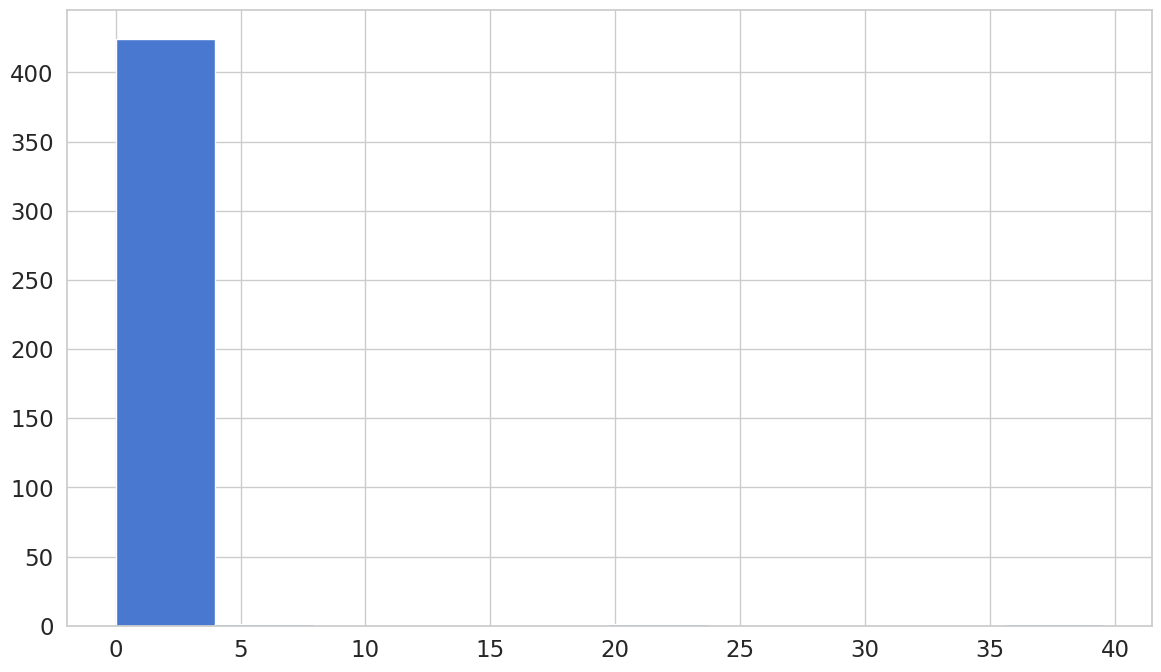

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

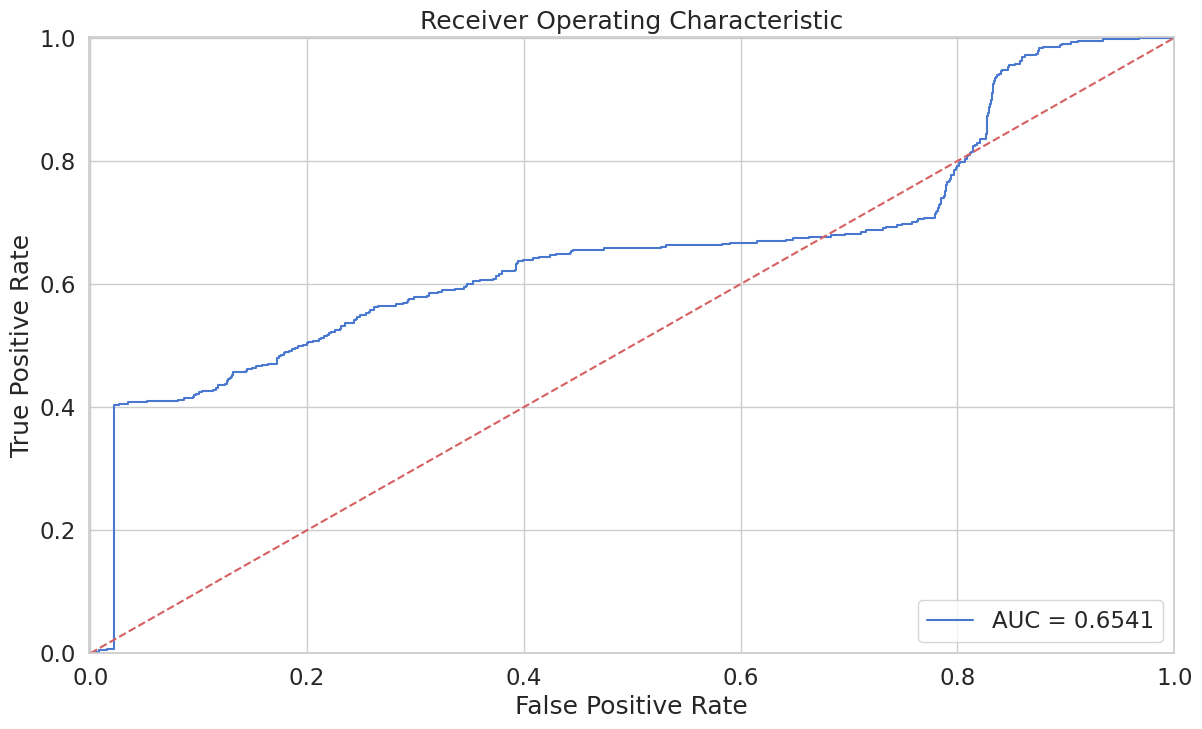

In [32]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF['Class'], reconstructionErrorDF['pred_loss'])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

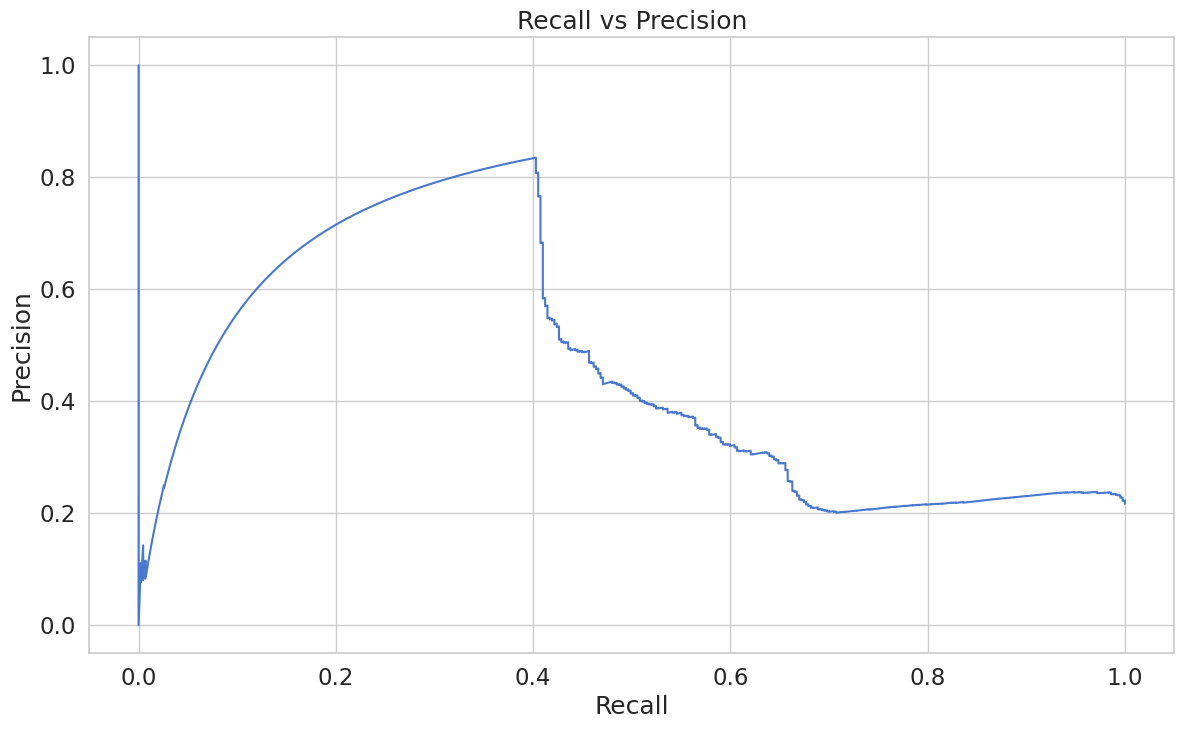

In [33]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

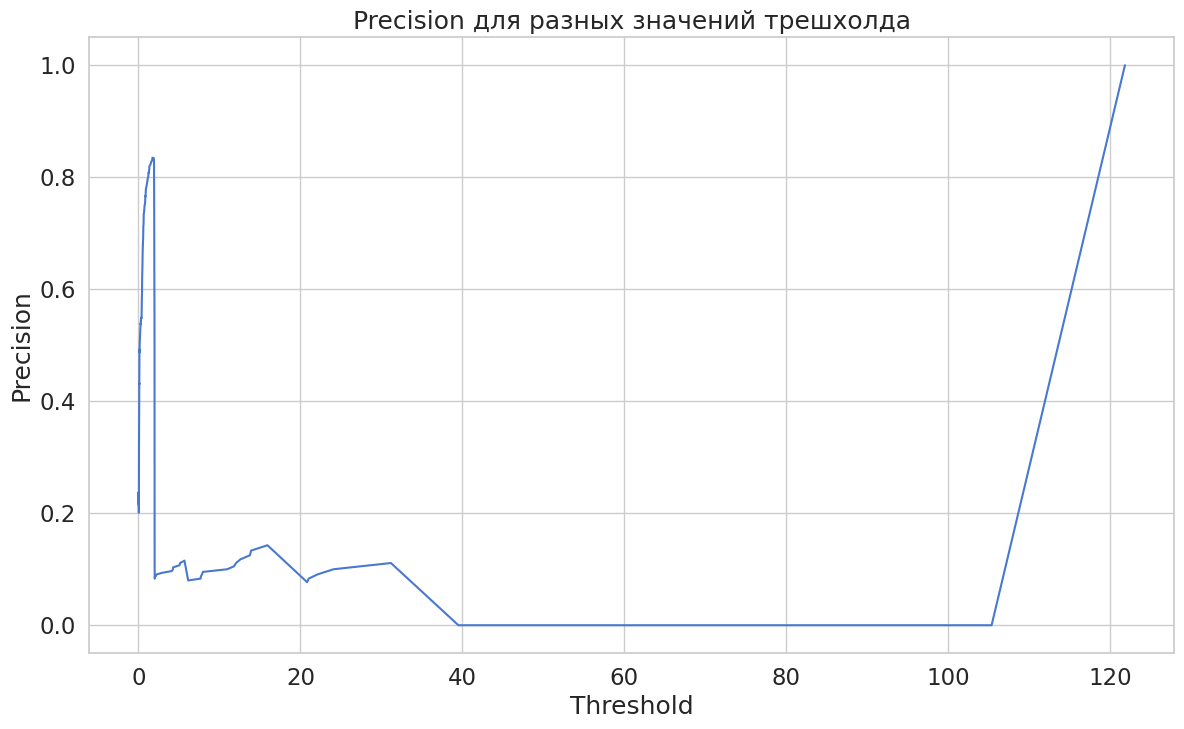

In [34]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


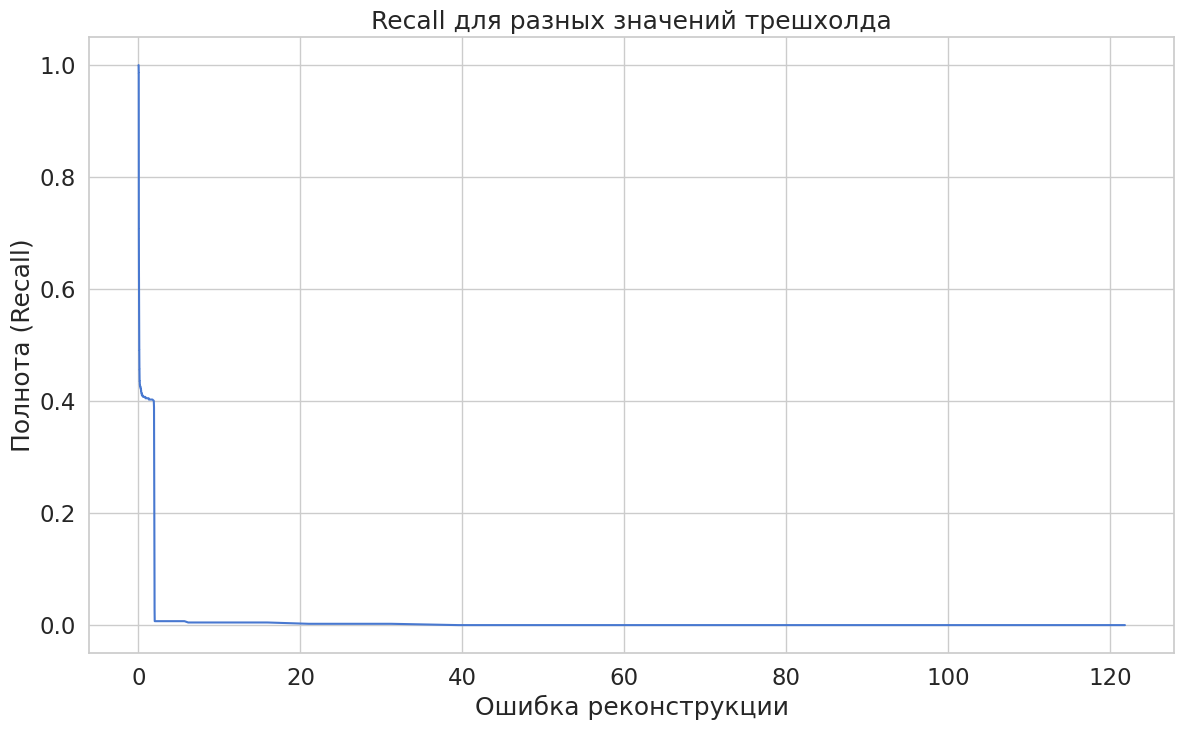

In [35]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

Чтобы предсказать, является ли новая/невидимая транзакция нормальной или мошеннической, мы рассчитаем ошибку реконструкции на основе самих данных транзакции. Если ошибка превышает предопределенный порог, мы помечаем ее как мошенничество (поскольку наша модель должна иметь низкую ошибку при обычных транзакциях). Давайте выберем это значение:

In [54]:
threshold = 0.09

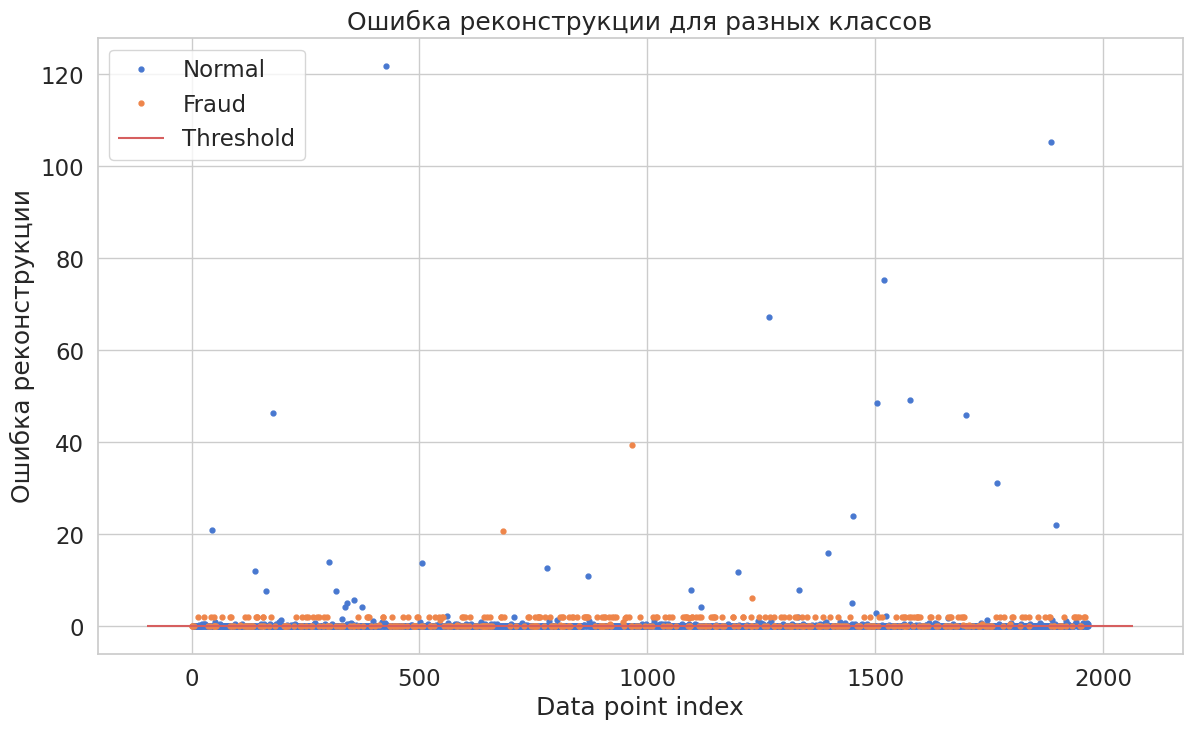

In [55]:
groups = reconstructionErrorDF.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

<ipython-input-56-11f70cc5c840>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


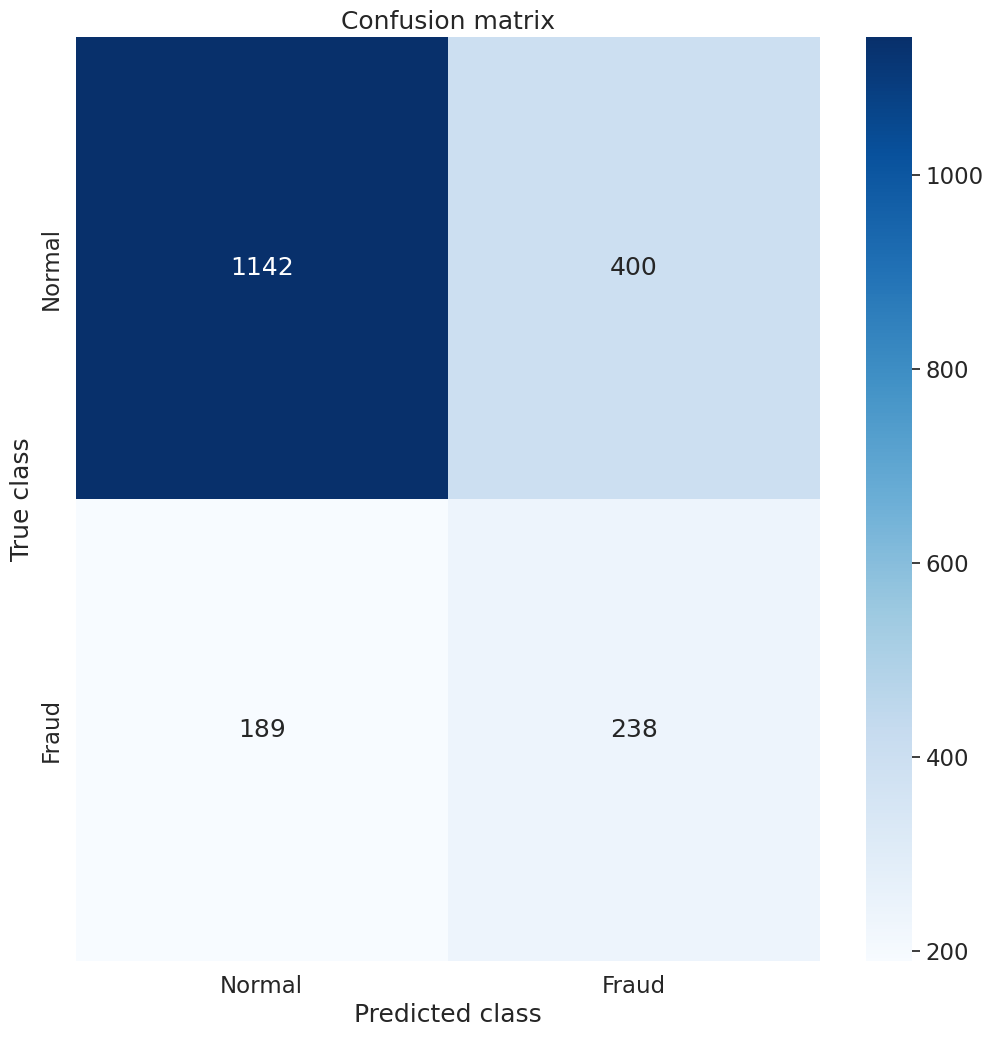

In [56]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()